# Initialize Notebook

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
from matplotlib.animation import FuncAnimation
from matplotlib import cm
import matplotlib.patheffects as pe
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
import ROOT
import uproot
import os
import sys
import tqdm
import pandas as pd
import pickle as pkl
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

%jsroot on
# %matplotlib qt
%matplotlib inline

In [2]:
sys.path.append('../python/')
from filterMethods import *
from gridMethods import *
from trackReconstructionMethods import *
from vertexReconstructionMethods import *
from hitAccuracyMethods import *
from statisticsMethods import *
from importMethods import *
from constants import *
import plotParameters

In [3]:
os.environ['PYDEVD_DISABLE_FILE_VALIDATION'] = '1'

# Load Data

In [4]:
fileName = '/Users/noah-everett/Documents/FNAL/Geant4/USSD_Geant4/runs/calibration_2.42^3_10000gamma_1000events.root'
histDir = '/photoSensor_hits_histograms'
print(get_histogram_names    (fileName, histDir))
print(get_histogram_titles   (fileName, histDir))
print(get_histogram_positions(fileName, histDir))
print(get_histogram_walls    (fileName, histDir))

['photoSensor_0;1', 'photoSensor_1;1', 'photoSensor_2;1', 'photoSensor_3;1', 'photoSensor_4;1', 'photoSensor_5;1', 'photoSensor_6;1', 'photoSensor_7;1', 'photoSensor_8;1', 'photoSensor_9;1', 'photoSensor_10;1', 'photoSensor_11;1', 'photoSensor_12;1', 'photoSensor_13;1', 'photoSensor_14;1', 'photoSensor_15;1', 'photoSensor_16;1', 'photoSensor_17;1', 'photoSensor_18;1', 'photoSensor_19;1', 'photoSensor_20;1', 'photoSensor_21;1', 'photoSensor_22;1', 'photoSensor_23;1', 'photoSensor_24;1', 'photoSensor_25;1', 'photoSensor_26;1', 'photoSensor_27;1', 'photoSensor_28;1', 'photoSensor_29;1', 'photoSensor_30;1', 'photoSensor_31;1', 'photoSensor_32;1', 'photoSensor_33;1', 'photoSensor_34;1', 'photoSensor_35;1', 'photoSensor_36;1', 'photoSensor_37;1', 'photoSensor_38;1', 'photoSensor_39;1', 'photoSensor_40;1', 'photoSensor_41;1', 'photoSensor_42;1', 'photoSensor_43;1', 'photoSensor_44;1', 'photoSensor_45;1', 'photoSensor_46;1', 'photoSensor_47;1', 'photoSensor_48;1', 'photoSensor_49;1', 'photoSen

In [5]:
treeName = 'photoSensor_hits;1'
df_hits = pd.DataFrame(columns=['sensor_name', 'sensor_direction', 'sensor_position', 'relativePosition', 'relativePosition_binned', 'time'])
df_hits['sensor_name'            ] = get_photosensor_hits_photosensor_ID          (fileName, treeName)
df_hits['sensor_direction'       ] = get_photosensor_hits_photosensor_direction   (fileName, treeName)
df_hits['sensor_position'        ] = get_photosensor_hits_photosensor_position    (fileName, treeName)
df_hits['relativePosition'       ] = get_photosensor_hits_position_relative       (fileName, treeName)
df_hits['relativePosition_binned'] = get_photosensor_hits_position_relative_binned(fileName, treeName, histDir)
df_hits['relativePosition_nBin'  ] = get_photosensor_hits_position_relative_nBin  (fileName, treeName, histDir)
df_hits['initialPosition'        ] = get_photosensor_hits_position_initial        (fileName, treeName)
df_hits['time'                   ] = get_photosensor_hits_time                    (fileName, treeName)
print('df_hits length:', len(df_hits))

df_hits length: 18374


# Filter Hits

In [6]:
search_radius = 0
search_number = 0

df_hits = filter_hits(df_hits, radius=search_radius, number=search_number)

# Basic Hit Reco

In [7]:
def rToTheta(r):
    return r/(CM_PER_RAD*MM_PER_CM)
df_hits = make_r(df_hits)
df_hits = filter_r(df_hits, Y_LIM)
df_hits = make_theta(df_hits, rToTheta)
df_hits = make_phi(df_hits)
df_hits = make_reconstructedVector_direction(df_hits)

# Plotting Parameters

In [8]:
twilight = cm.twilight(np.linspace(0,1,40))

# Make Grid

In [9]:
grid, grid_ind, grid_pos = get_voxelGrid(
    (30, 30, 30),
    DETECTOR_SIZE_MM,
    np.array(df_hits['sensor_position'].to_list()).reshape(-1,3),
    np.array(df_hits['reconstructedVector_direction'].to_list()).reshape(-1,3),
    [1 for i in range(len(df_hits))],
    20,
    True
)

/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_53144/3966560590.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


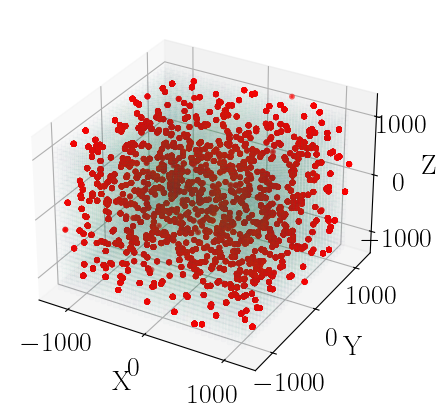

In [10]:
# %matplotlib qt
# %matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
voxelGrid = ax.scatter(grid_pos[:,0],
                       grid_pos[:,1],
                       grid_pos[:,2],  
                       c=grid[grid >= 0],
                       cmap='viridis',
                       marker='s',
                       alpha=0.01,
                       s=10,
                       norm=LogNorm())  # Use LogNorm for log scale
track = ax.scatter(np.array(df_hits['initialPosition'].to_list()).reshape(-1,3)[:,0],
                   np.array(df_hits['initialPosition'].to_list()).reshape(-1,3)[:,1],
                   np.array(df_hits['initialPosition'].to_list()).reshape(-1,3)[:,2],
                   c='r',
                   marker='o',
                   s=5,
                   linewidth=2)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
sm = plt.cm.ScalarMappable(cmap='viridis', norm=LogNorm())
sm.set_array(grid[grid > 0])
# cbar = fig.colorbar(sm, ax=ax, label='Color Bar (Log Scale)')
fig.show()

In [11]:
size = (30, 30, 30)
makeErrors = False

In [12]:
grids, grid_inds, grid_poss = [], [], []
for IP in tqdm.tqdm(np.unique(df_hits['initialPosition'].to_numpy())):
    inds = df_hits['initialPosition'] == IP
    grid, grid_ind, grid_pos = get_voxelGrid(
        size,
        DETECTOR_SIZE_MM,
        np.array(df_hits['sensor_position'][inds].to_list()).reshape(-1,3),
        np.array(df_hits['reconstructedVector_direction'][inds].to_list()).reshape(-1,3),
        [1 for i in range(len(df_hits[inds]))],
        20,
        makeErrors
    )
    grids.append(grid)
    grid_inds.append(grid_ind)
    grid_poss.append(grid_pos)

  0%|          | 0/999 [00:00<?, ?it/s]

100%|██████████| 999/999 [00:40<00:00, 24.64it/s]


In [58]:
X = np.array(grids).reshape(-1, size[0], size[1], size[2])
Y = np.unique(np.array(df_hits['initialPosition'].to_list()).reshape(-1,3), axis=0)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print('X_test shape:',  X_test.shape)
print('Y_test shape:',  Y_test.shape)

X_train shape: (799, 30, 30, 30)
Y_train shape: (799, 3)
X_test shape: (200, 30, 30, 30)
Y_test shape: (200, 3)


# Model

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 30, 30, 30, 1)]   0         
                                                                 
 conv3d_43 (Conv3D)          (None, 28, 28, 28, 1)     28        
                                                                 
 flatten_20 (Flatten)        (None, 21952)             0         
                                                                 
 dense_62 (Dense)            (None, 64)                1404992   
                                                                 
 dense_63 (Dense)            (None, 32)                2080      
                                                                 
 dense_64 (Dense)            (None, 3)                 99        
                                                                 
Total params: 1,407,199
Trainable params: 1,407,199
Non-tr

Epoch 1/100
25/25 [==============================] - 3s 126ms/step - loss: 465423.2500 - val_loss: 446632.8750
Epoch 2/100
25/25 [==============================] - 3s 124ms/step - loss: 465285.0312 - val_loss: 446642.5625
Epoch 3/100
25/25 [==============================] - 3s 126ms/step - loss: 465271.5625 - val_loss: 446615.9062
Epoch 4/100
25/25 [==============================] - 3s 128ms/step - loss: 465266.0312 - val_loss: 446616.4688
Epoch 5/100
25/25 [==============================] - 3s 122ms/step - loss: 465263.1250 - val_loss: 446616.2500
Epoch 6/100
25/25 [==============================] - 3s 122ms/step - loss: 465261.6250 - val_loss: 446610.0312
Epoch 7/100
25/25 [==============================] - 3s 122ms/step - loss: 465261.0625 - val_loss: 446610.4688
Epoch 8/100
25/25 [==============================] - 3s 123ms/step - loss: 465260.8438 - val_loss: 446610.1250
Epoch 9/100
25/25 [==============================] - 3s 122ms/step - loss: 465260.6562 - val_loss: 446609.7188
E

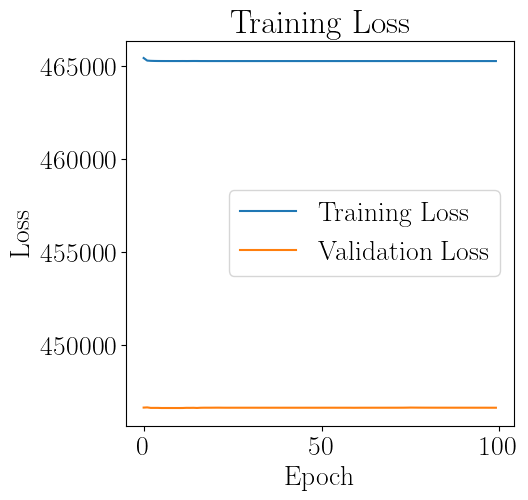

In [70]:
def directional_convolution_model():
    size_ = (size[0], size[1], size[2], 1)
    input = tf.keras.Input(shape=size_)

    # conv_x = tf.keras.layers.Conv3D(filters=32, kernel_size=(1, 3, 3), padding='same', activation='relu')(input)
    # conv_y = tf.keras.layers.Conv3D(filters=32, kernel_size=(3, 1, 3), padding='same', activation='relu')(input)
    # conv_z = tf.keras.layers.Conv3D(filters=32, kernel_size=(3, 3, 1), padding='same', activation='relu')(input)
    # sum_conv = tf.keras.layers.add([conv_x, conv_y, conv_z])
    # flatten = tf.keras.layers.Flatten()(sum_conv)

    conv_1 = tf.keras.layers.Conv3D(filters=1, kernel_size=(3, 3, 3), padding='valid', activation='relu')(input)
    flatten = tf.keras.layers.Flatten()(conv_1)

    dense_1 = tf.keras.layers.Dense(units=64, activation='relu')(flatten)
    dense_2 = tf.keras.layers.Dense(units=32, activation='relu')(dense_1)

    output = tf.keras.layers.Dense(units=3, activation='softmax')(dense_2)

    model = tf.keras.models.Model(inputs=input, outputs=output)

    return model

model = directional_convolution_model()
model.summary()
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, Y_train, epochs=100, validation_data=(X_test, Y_test))

# Plot the training
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [95]:
df_hits['reconstructedPosition'] = [0 for i in range(len(df_hits))]
for grid, IP in tqdm.tqdm(zip(grids, np.unique(df_hits['initialPosition'].to_numpy()))): # zip(X, Y)
    inds = df_hits['initialPosition'] == IP
    RP = model.predict(grid.reshape(-1, size[0], size[1], size[2],1), verbose=0)[0]
    df_hits['reconstructedPosition'][inds] = [RP for i in range(np.sum(inds))]

0it [00:00, ?it/s]/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_53144/3082116245.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hits['reconstructedPosition'][inds] = [RP for i in range(np.sum(inds))]
/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_53144/3082116245.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[array([1.474767e-23, 1.000000e+00, 2.611871e-32], dtype=float32), array([1.474767e-23, 1.000000e+00, 2.611871e-32], dtype=float32), array([1.474767e-23, 1.000000e+00, 2.611871e-32], dtype=float32), array([1.474767e-23, 1.000000e+00, 2.611871e-32], dtype=float32), array([1.474767e-23, 1.000000e+00, 2.611871e-32], dtype=float32), array([1.474767e-23, 1.000000e+00, 2.611871e-32], dtype=float

ValueError: cannot assign mismatch length to masked array

In [13]:
true_mean = np.array(df_hits['initialPosition'         ].to_list()).reshape(-1,3)
reco_mean = np.array(df_hits['reconstructedVertex_mean'].to_list()).reshape(-1,3)
true_mean = true_mean[~np.isnan(reco_mean).any(axis=1)]
reco_mean = reco_mean[~np.isnan(reco_mean).any(axis=1)]
inds_mean = np.unique(reco_mean, axis=0, return_index=True)[1]
true_mean = true_mean[inds_mean]
reco_mean = reco_mean[inds_mean]
distances_mean = np.linalg.norm(true_mean - reco_mean, axis=1)

true_max = np.array(df_hits['initialPosition'        ].to_list()).reshape(-1,3)
reco_max = np.array(df_hits['reconstructedVertex_max'].to_list()).reshape(-1,3)
true_max = true_max[~np.isnan(reco_max).any(axis=1)]
reco_max = reco_max[~np.isnan(reco_max).any(axis=1)]
inds_max = np.unique(reco_max, axis=0, return_index=True)[1]
true_max = true_max[inds_max]
reco_max = reco_max[inds_max]
distances_max = np.linalg.norm(true_max - reco_max, axis=1)

KeyError: 'reconstructedVertex_mean'

/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_90949/2810443522.py:42: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


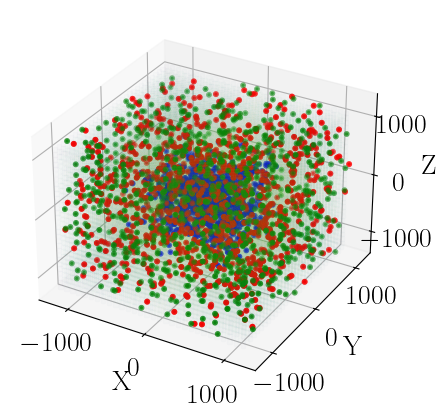

In [ ]:
# %matplotlib qt
# %matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
voxelGrid = ax.scatter(grid_pos[:,0],
                       grid_pos[:,1],
                       grid_pos[:,2],  
                       c=grid[grid >= 0],
                       cmap='viridis',
                       marker='s',
                       alpha=0.01,
                       s=10,
                       norm=LogNorm())  # Use LogNorm for log scale
vertex_true = ax.scatter(np.concatenate((true_mean[:,0], true_max[:,0])),
                         np.concatenate((true_mean[:,1], true_max[:,1])),
                         np.concatenate((true_mean[:,2], true_max[:,2])),
                         c='r',
                         marker='o',
                         s=5,
                         linewidth=2)
vertex_mean = ax.scatter(reco_mean[:,0],
                         reco_mean[:,1],
                         reco_mean[:,2],
                         c='b',
                         marker='o',
                         s=5,
                         linewidth=2)
vertex_max = ax.scatter(reco_max[:,0],
                        reco_max[:,1],
                        reco_max[:,2],
                        c='g',
                        marker='o',
                        s=5,
                        linewidth=2)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
sm = plt.cm.ScalarMappable(cmap='viridis', norm=LogNorm())
sm.set_array(grid[grid > 0])
# cbar = fig.colorbar(sm, ax=ax, label='Color Bar (Log Scale)')
fig.show()

/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_90949/3843221228.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<Figure size 500x500 with 0 Axes>

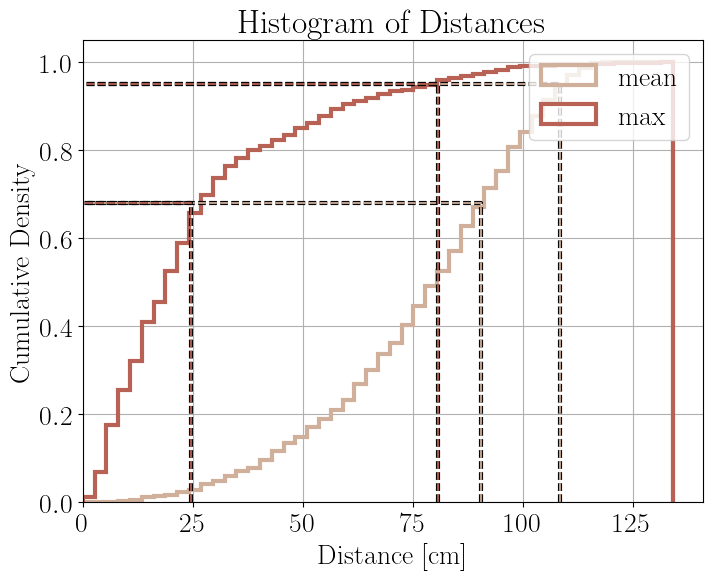

In [ ]:
nBins = 50
scale = 10
lw = 3
cum = True
savePlots = False

PDF, _, _, bins = get_PDF(distances_mean/scale, nBins=nBins)
sigma_1_mean = get_CSP('1 sigma', PDF=PDF, bins=bins)
sigma_2_mean = get_CSP('2 sigma', PDF=PDF, bins=bins)

PDF, _, _, bins = get_PDF(distances_max/scale, nBins=nBins)
sigma_1_max = get_CSP('1 sigma', PDF=PDF, bins=bins)
sigma_2_max = get_CSP('2 sigma', PDF=PDF, bins=bins)

bins = np.linspace(0, np.max(np.concatenate((distances_mean, distances_max)))/scale, nBins+1)

fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(distances_mean/scale, bins=bins, alpha=1, histtype='step', cumulative=cum, density=True, label='mean', linewidth=lw, color=twilight[35, :], linestyle='-')
ax.hist(distances_max /scale, bins=bins, alpha=1, histtype='step', cumulative=cum, density=True, label='max' , linewidth=lw, color=twilight[30, :], linestyle='-')
ax.plot([sigma_1_mean, sigma_1_mean, 0], [0, 0.68, 0.68], color=twilight[35, :], linewidth=1.5, alpha=0.9, path_effects=[pe.Stroke(linewidth=3, foreground='k'), pe.Normal()], linestyle='--')
ax.plot([sigma_2_mean, sigma_2_mean, 0], [0, 0.95, 0.95], color=twilight[35, :], linewidth=1.5, alpha=0.9, path_effects=[pe.Stroke(linewidth=3, foreground='k'), pe.Normal()], linestyle='--')
ax.plot([sigma_1_max , sigma_1_max , 0], [0, 0.68, 0.68], color=twilight[30, :], linewidth=1.5, alpha=0.9, path_effects=[pe.Stroke(linewidth=3, foreground='k'), pe.Normal()], linestyle='--')
ax.plot([sigma_2_max , sigma_2_max , 0], [0, 0.95, 0.95], color=twilight[30, :], linewidth=1.5, alpha=0.9, path_effects=[pe.Stroke(linewidth=3, foreground='k'), pe.Normal()], linestyle='--')
ax.set_xlabel('Distance [cm]')
ax.set_ylabel('Cumulative Density')
ax.set_title('Histogram of Distances')
ax.set_xlim(xmin=0)
ax.legend(loc='upper right')
ax.grid()

if savePlots:
    fig.savefig('../figures/trackReconstruction_distances_cum.pdf', bbox_inches='tight')

fig.show()


/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_90949/1445706108.py:30: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<Figure size 500x500 with 0 Axes>

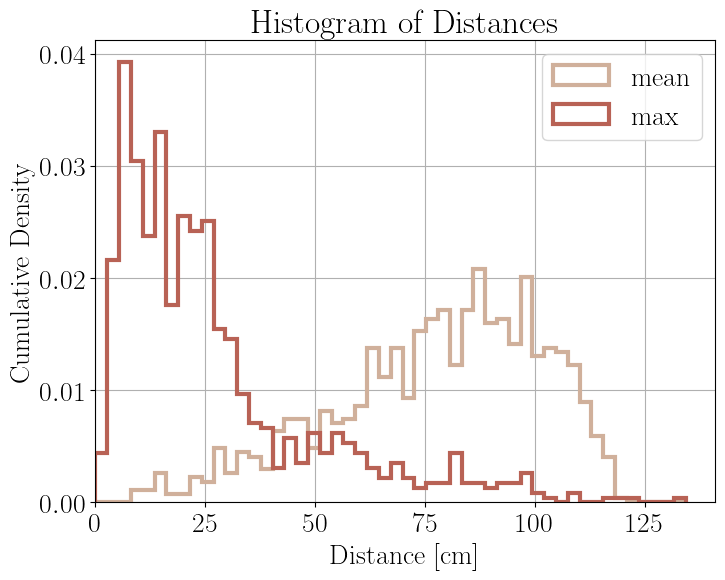

In [ ]:
nBins = 50
scale = 10
lw = 3
cum = False
savePlots = False

PDF, _, _, bins = get_PDF(distances_mean/scale, nBins=nBins)
sigma_1_mean = get_CSP('1 sigma', PDF=PDF, bins=bins)
sigma_2_mean = get_CSP('2 sigma', PDF=PDF, bins=bins)

PDF, _, _, bins = get_PDF(distances_max/scale, nBins=nBins)
sigma_1_max = get_CSP('1 sigma', PDF=PDF, bins=bins)
sigma_2_max = get_CSP('2 sigma', PDF=PDF, bins=bins)

bins = np.linspace(0, np.max(np.concatenate((distances_mean, distances_max)))/scale, nBins+1)

fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(distances_mean/scale, bins=bins, alpha=1, histtype='step', cumulative=cum, density=True, label='mean', linewidth=lw, color=twilight[35, :], linestyle='-')
ax.hist(distances_max /scale, bins=bins, alpha=1, histtype='step', cumulative=cum, density=True, label='max' , linewidth=lw, color=twilight[30, :], linestyle='-')
ax.set_xlabel('Distance [cm]')
ax.set_ylabel('Cumulative Density')
ax.set_title('Histogram of Distances')
ax.set_xlim(xmin=0)
ax.legend(loc='upper right')
ax.grid()

if savePlots:
    fig.savefig('../figures/trackReconstruction_distances_nonCum.pdf', bbox_inches='tight')

fig.show()
